In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sqlite3 as lite
import pandas as pd
import tables as tb
from IPython.display import clear_output
import csv
import quandl
from scipy import stats
import time
from matplotlib.lines import Line2D

np.random.seed(777)
quandl.ApiConfig.api_key = "UzB-e5CDdoACq4ENxbVS"

In [2]:
def westerncandlestick(ax, quotes, width=0.2, colorup='r', colordown='k',linewidth=0.5):

    OFFSET = width / 2.0

    lines = []
    openlines = []
    closelines = []
    for q in quotes:
        t, open, high, low, close = q[:5]

        if close > open:
            color = colorup
        else:
            color = colordown

        vline = Line2D( xdata=(t, t), ydata=(low, high), color=color, linewidth=linewidth, antialiased=True)
        lines.append(vline)

        openline = Line2D(xdata=(t - OFFSET, t), ydata=(open,open), color=color, linewidth=linewidth, antialiased=True)
        openlines.append(openline)

        closeline = Line2D(xdata=(t , t+OFFSET), ydata=(close,close), color=color, linewidth=linewidth, antialiased=True)
        closelines.append(closeline)

        ax.add_line(vline)
        ax.add_line(openline)
        ax.add_line(closeline)
    
    ax.axhline(linewidth=1, color='g')
    ax.axvline(x=int(t/2), linewidth=1, color='g')
    ax.autoscale_view()

    return lines, openlines, closelines

In [8]:
# quandl에서 backward panama adjusted continuous contracts 자료 받기
df = pd.read_csv('data/SCF-meta.csv')
df['iid'] = 'SCF/'+df.Exchange+'_'+df.Symbol+'1_OB'
meta = df[['iid','name']]

In [11]:
meta.head()

,iid,name
0,SCF/CME_CL1_OB,NYMEX WTI Crude Oil
1,SCF/CME_LN1_OB,CME Lean Hogs
2,SCF/CME_W1_OB,CBOT Wheat
3,SCF/CME_NK1_OB,CME Nikkei 225
4,SCF/CME_S1_OB,CBOT Soybeans


In [ ]:
WINDOW = 60

CBOT Oats Futures #1 (O1) - Front Month - Backwards Panama Adjusted Prices, Roll on Open Interest Switc
hurst exponent:  0.561515086415


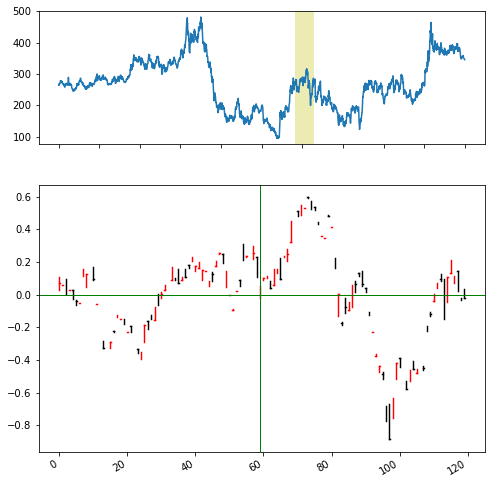

하락(0), 기타(1),  상승(2): q


In [31]:
window = 120
while True:
    idx = np.random.randint(0, len(codes))
    code = codes.iloc[idx].code
    content = codes.iloc[idx].contents

    raw_data = quandl.get(code)
    raw_data.drop(['Volume', 'Prev. Day Open Interest'], axis=1, inplace=True)
    std = raw_data.Settle.std()
    #log_change = np.log( (raw_data/raw_data.shift(1)).dropna().drop(['Volume', 'Prev. Day Open Interest'], axis=1) )
    #mean = np.abs(log_change.Settle).mean()
    #normed_data = log_change/mean
    length = len(raw_data)
    #hurst exponent -- why need?
    #slope, intercept, logx, logy = hurst_exp(raw_data.Settle)
    
    for i in range(10):
        print(content[:-30])
        #print('\nHurst exponent: ', slope)
        
        #시작일자 랜덤 설정
        start = np.random.randint(0, length -  window)
        end = start + window

        #Data Normalization
        #data = normed_data[start:end].cumsum()
        #data.insert(0, 'index', np.arange(len(data)) )
        data = raw_data[start:end]
        data = (data-data.Settle.mean())/std
        data.insert(0, 'index', np.arange(len(data)))
        
        #그래프 
        fig, (ax) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1, 2]}, figsize=(8,9))
        fig.autofmt_xdate()
            
        ax[0].plot(raw_data.index.values, raw_data.Settle.values)
        ax[0].axvspan(raw_data.index.values[start], raw_data.index.values[end], facecolor='y', alpha=0.3)
        
        #ax2 = plt.subplot(3,1,3)
        #ax[1].plot(x,y, 'm.')
        #ax[1].axhline(linewidth=1, color='g')
        #ax[1].axvline(x=x[int(len(x)/2)], linewidth=1, color='g')
        westerncandlestick(ax[1], data.values, linewidth=1.44)
        
        
        rps, logx, slope, intercept = rescaled_range(data.Settle)
        print("hurst exponent: ", slope)
        plt.show()
        
        #추세 입력
        time.sleep(0.1)
        trend = input("하락(0), 기타(1),  상승(2): ")
        if trend == 'q' or trend == 'n':
            break
        elif trend in ['0','1','2']:
            seq = np.array([[int(trend)], [int(trend)], [int(trend)], [int(trend)]])
            data.drop('index', axis=1, inplace=True)
            row = np.hstack((data.values.T, seq))
            
            with open('data/120day_trend(normed_by_globalstd)_2.csv', 'ab') as file:
                np.savetxt(file, row, fmt='%.7f', delimiter=',')
        
        clear_output(wait=True)
    if trend == 'q':
            break
    clear_output(wait=True)

In [29]:
d = np.genfromtxt('data/120day_trend(normed_by_globalstd)_2.csv', delimiter=',')

In [30]:
d

array([[-0.5023531, -0.4822212, -0.5690867, ...,  0.290993 ,  0.2932299,
         2.       ],
       [-0.4479224, -0.4714097, -0.5601392, ...,  0.318954 ,  0.307024 ,
         2.       ],
       [-0.5493276, -0.5825079, -0.6697462, ...,  0.2589311,  0.2641505,
         2.       ],
       ..., 
       [-0.7328209, -0.7431808, -0.6269876, ...,  0.8315207,  0.8851483,
         2.       ],
       [-0.838451 , -0.8047306, -0.7754792, ...,  0.5993376,  0.7319846,
         2.       ],
       [-0.7756823, -0.7734478, -0.6519732, ...,  0.8067383,  0.7494542,
         2.       ]])